In [9]:

# Importing the os module for interacting with the operating system
import os

# Importing pandas for data manipulation and analysis
import pandas as pd

# Importing matplotlib.pyplot for plotting
import matplotlib.pyplot as plt

# Importing numpy for numerical operations
import numpy as np

# Importing specific functions from scipy.signal for signal processing
from scipy.signal import butter, filtfilt, sosfiltfilt
from scipy.signal import find_peaks, peak_prominences, peak_widths

# Importing Tcl from tkinter for GUI operations
from tkinter import Tcl



# Importing make_subplots from plotly.subplots for creating subplot figures
from plotly.subplots import make_subplots


# Importing cm from matplotlib for colormap handling
from matplotlib import cm

# Importing matplotlib as mpl and setting rcParams for matplotlib configurations
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

# Enabling the matplotlib widget backend for interactive plots (commented out as it's not always needed)
#%matplotlib widget

In [10]:
# Bandpass filter

def translation(order, Wn, btype, fs, x):
    a,b = butter(order, Wn, btype, fs = fs)
    x_f= filtfilt(a,b, x)
    return x_f
# find the nearest value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
#convert from timestamp to seconds
def timestamps_to_seconds(timestamps, starttime):
    """
    Convert a list of timestamps in "hh:mm" format into seconds.

    Parameters:
    timestamps (list): The list of timestamps to convert.

    Returns:
    list: A list of times converted into seconds.
    """
    seconds = []
    # convert the first timestamp into seconds and use it as start_time
    start_min, start_sec = map(int, starttime.split(':'))
    start_time = start_min * 60 + start_sec 
    
    for timestamp in timestamps:
        # split the timestamp into hours and minutes
        minu, sec = map(int, timestamp.split(':'))
        # convert to seconds and subtract start_time
        seconds.append(minu * 60 + sec  - start_time)
        
    return seconds
#Function that finds peaks with the find_peak function. Afterwards filters out all peaks that are to close to start and end of the data. 

def find_peaks_with_window(data, window, **kwargs):
    peaks, properties = find_peaks(data, **kwargs)
    
    # filter out peaks near the start and end of the data
    valid_indices = (peaks >= 5*window) & (peaks <= len(data) - 5*window)
    peaks = peaks[valid_indices]
    
    # filter properties with valid_indices
    for key in properties:
        properties[key] = properties[key][valid_indices]
    
    return peaks, properties
def estimate_peak_widths(signal, fs,big_counts):
    """
    Estimate average peak width in the signal.
    
    Parameters:
    - signal: input signal
    - fs: sampling frequency
    
    Returns:
    - avg_width: average width of peaks in seconds
    """
    peaks, _ = find_peaks(signal,  width=[1,2000], prominence=big_counts, distance=1000)
    widths = peak_widths(signal, peaks, rel_height=0.8)[0]
    avg_width = np.percentile(widths,10) / fs
    return avg_width

def adjust_lowpass_cutoff(signal, fs, big_counts, initial_cutoff=1.0):
    """
    Adjust the lowpass filter cut-off based on peak width.
    
    Parameters:
    - signal: input signal
    - fs: sampling frequency
    - initial_cutoff: initial cut-off frequency
    
    Returns:
    - filtered_signal: filtered signal with adjusted cut-off frequency
    """
    avg_width = estimate_peak_widths(signal, fs,big_counts)
    print(avg_width)
    # Adjust the cut-off frequency based on peak width (example heuristic)
    cutoff = initial_cutoff / avg_width  # Adjust cut-off frequency based on peak width
    print(cutoff)
    # Ensure the cutoff frequency is within a reasonable range
    cutoff = max(min(cutoff, 10000), 50)
    print(cutoff)
    # Design and apply lowpass filter
    order = 2
    btype = 'lowpass'
    filtered_signal=translation(order, cutoff, btype, fs,signal)
    
    return filtered_signal

In [11]:
# folder path
dir_path = os.getcwd()
# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        if path.endswith('.txt'):
            res.append(path)
print(res)
files=res
#sort filenames
files=Tcl().call('lsort', '-dict', res)

['841 1.txt', '841 10.txt', '841 11.txt', '841 12.txt', '841 13.txt', '841 14.txt', '841 15.txt', '841 16.txt', '841 2.txt', '841 3.txt', '841 4.txt', '841 5.txt', '841 6.txt', '841 7.txt', '841 8.txt', '841 9.txt']


In [15]:
files

('841 1.txt',
 '841 2.txt',
 '841 3.txt',
 '841 4.txt',
 '841 5.txt',
 '841 6.txt',
 '841 7.txt',
 '841 8.txt',
 '841 9.txt',
 '841 10.txt',
 '841 11.txt',
 '841 12.txt',
 '841 13.txt',
 '841 14.txt',
 '841 15.txt',
 '841 16.txt')

In [17]:
#start time of measuremnt set
start_time="0:00"
timestamps=['2:10', '4:10', '7:40', '9:40', '13:20', '15:20', '19:30', '21:30', '24:30', '26:30', '30:30', '32:30', '35:20', '37:20', '40:40', '42:40', '45:50', '47:50', '51:00', '53:00']

time_stemps= timestamps_to_seconds(timestamps,start_time)

In [6]:
time_stemps

[130,
 250,
 460,
 580,
 800,
 920,
 1170,
 1290,
 1470,
 1590,
 1830,
 1950,
 2120,
 2240,
 2440,
 2560,
 2750,
 2870,
 3060,
 3180]

In [9]:
#load data and combine to one dataframe
x=[]
t=[]
i=0
for name in files:
    df = pd.read_csv(name, skiprows=1, sep='\t' ,names=["time","value"])
    t_new=df['time'].to_numpy()
    x_new=df['value'].to_numpy()
    t=np.append(t,time_stemps[i]*1e4+t_new)
    x=np.append(x,x_new)
    i+=1

In [19]:
x=[]
t=[]
border=np.zeros(len(files))
i=0
for name in files:
    df = pd.read_csv(name, skiprows=1, sep='\t' ,names=["time","value"])
    t_new=df['time'].to_numpy()
    x_new=df['value'].to_numpy()
    if name == files[0]:
        t=t_new
        x=x_new
        border[i]=t_new[-1]
        i+=1
    else:
        t=np.append(t,max(t)+t_new)
        x=np.append(x,x_new)
        border[i]=t[-1]
        i+=1

In [20]:
# the height of you bigger signals
big_counts=40 #<----Adjust------>

In [21]:
#time to secounds
t=t*1e-4
rate=1e-4
fs = 1/rate
filtered_signal = adjust_lowpass_cutoff(x, fs,big_counts)

0.0007958404762204737
1256.5332247853244
1256.5332247853244


In [22]:
order = 2
btype = 'lowpass'
cutoff= 1500
filtered_signal=translation(order, cutoff, btype, fs,x)

In [23]:
#filtered_signal=x

In [24]:
height_lim=7*np.std(filtered_signal)

In [25]:
height_lim=20

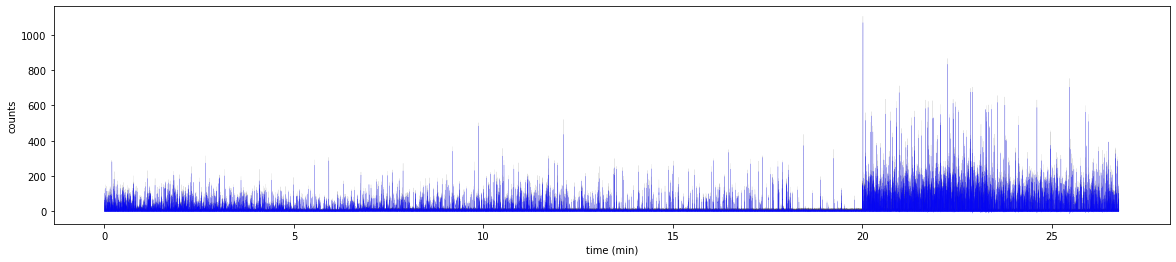

In [26]:
#inspect raw data and smoothed data
fig, ax = plt.subplots(figsize=(20, 4))
line,=ax.plot(t/60, x,color='black',linewidth=0.1,alpha=.5)
line,=ax.plot(t/60, filtered_signal,color='blue',linewidth=0.2,alpha=.7)
ax.set_xlabel('time (min)')
ax.set_ylabel('counts')
#plt.xlim(2.4,3)
#plt.ylim(0,50)
plt.show()

In [27]:
fig.savefig('timetrace.png', format="png", bbox_inches='tight')

In [28]:
window = 1000# <---------------- ADJUST----------------->

In [29]:
peaks_x_filter, amp_x_filter = find_peaks_with_window(filtered_signal, window, width=[1,2000], prominence=height_lim, distance=300,rel_height=0.85)

In [30]:
events=len(peaks_x_filter)

In [31]:
window=np.round(amp_x_filter['widths'],0).astype(int)+40

C:\Users\lucek\AppData\Local\Temp\ipykernel_26812\3572095680.py:5: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust space between plots


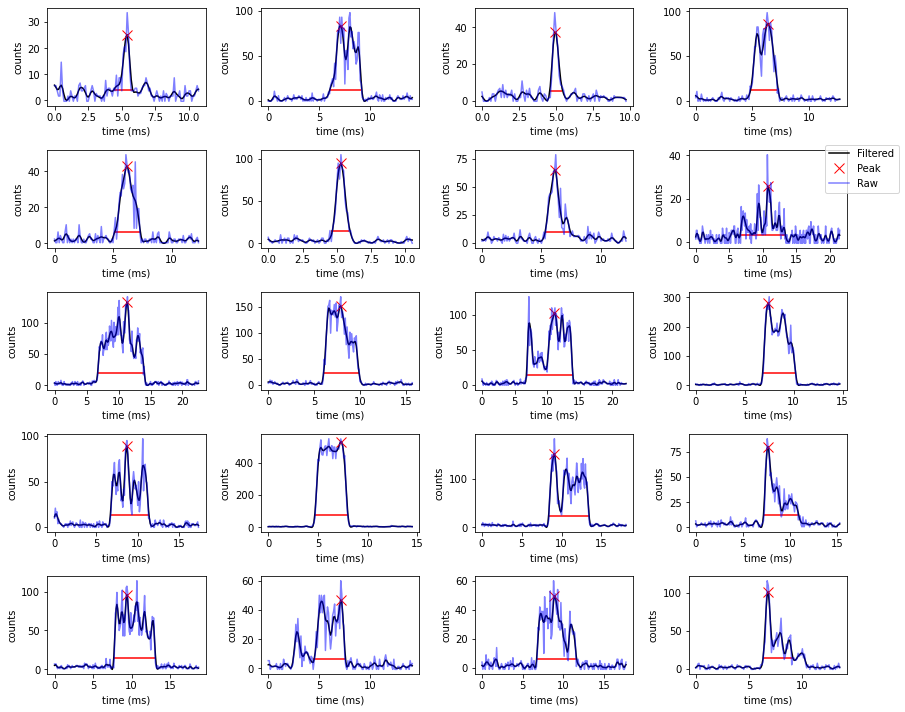

In [34]:
values = np.round(np.linspace(0, len(peaks_x_filter)-1, 20)).astype(int)

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(5, 4, figsize=(12, 10), constrained_layout=True)
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust space between plots

# Collect handles and labels for the legend
handles, labels = [], []

for idx, val in enumerate(values):
    i = val  # Index for the current event
    Datax = t
    xData = Datax[peaks_x_filter[i]-window[i]:peaks_x_filter[i]+window[i]]

    # Smoothed DATA
    Datay = filtered_signal
    yData = Datay[peaks_x_filter[i]-window[i]:peaks_x_filter[i]+window[i]]
    background = np.min(yData)  # Estimate background
    yData -= background

    # Determine the current subplot
    ax = axs[idx // 4, idx % 4]

    line1, = ax.plot((xData-xData[0])*1e3, yData, color='black', label='Filtered', alpha=1)
    line2, = ax.plot((t[peaks_x_filter[i]]-xData[0])*1e3, filtered_signal[peaks_x_filter[i]], "x", color='red', ms=10, label='Peak')
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('counts')

    # RAW data
    Datay = x
    yData = Datay[peaks_x_filter[i]-window[i]:peaks_x_filter[i]+window[i]]
    corrected_signal = yData - background
    line3, = ax.plot((xData-xData[0])*1e3, corrected_signal, color='blue', label='Raw', alpha=0.5)
    ax.hlines(y=amp_x_filter["width_heights"][i]-background, xmin=(t[int(amp_x_filter["left_ips"][i])]-xData[0])*1e3,xmax=(t[int(amp_x_filter["right_ips"][i])]-xData[0])*1e3, color = "red")


    # This is to ensure we only add the legend once
    if idx == 0:
        handles.extend([line1, line2, line3])
    
# Create a single legend for the whole figure
fig.legend(handles, [h.get_label() for h in handles], loc='upper right', bbox_to_anchor=(1.05, 0.8))

# Adjust layout to make room for the legend
plt.tight_layout()

# Save the figure
plt.savefig('my_figure.png', bbox_inches='tight')

# Show the figure
plt.show()


In [40]:
#Save example peak
fig.savefig('peaks_eaxample1.svg', format="svg", bbox_inches='tight')

In [51]:
peak_area=np.zeros(events)
start=np.zeros(events)
end=np.zeros(events)
Datay = filtered_signal  # This seems static, so moved outside the loop
# Precompute the static operations if any

# Optimize loop by minimizing operations inside it
for i in range(events):
    yData = Datay[peaks_x_filter[i] - window[i]:peaks_x_filter[i] + window[i]]
    background = np.min(yData)
    
    # Directly use the values if they are indices and if 't' directly corresponds to 'filtered_signal' indices
    st = int(amp_x_filter["left_ips"][i])
    en = int(amp_x_filter["right_ips"][i])
    
    start[i] = st
    end[i] = en
    
    peak_area[i] = np.sum(filtered_signal[st:en] - background)

In [53]:
# save all kind of peak information in a Dataframe
df_all = pd.DataFrame({"width": amp_x_filter['widths'], "amplitude":amp_x_filter['prominences'],  "t": t[peaks_x_filter],"area": peak_area} )
df_all.to_csv('single_A.csv', index=False) #save dataframe to csv file to analyse later 

In [55]:
intervall=10

points=len(np.arange(1,int(max(t)),intervall))
peaks=np.zeros(points)
peaks_intervall=np.zeros(points)
index=0
position=np.arange(1,int(max(t)),intervall)
for i in position: 
    
    peaks[index]=find_nearest(t[peaks_x_filter], i)
    if i==0:
        peaks_intervall[index]=peaks[index]
        index+=1
    else :
        peaks_intervall[index]=peaks[index]-peaks[index-1]
        index+=1

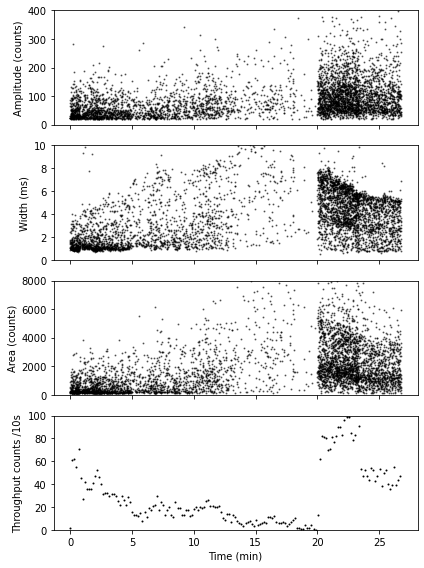

In [56]:

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(6, 8), sharex=True)  # Ensure axes are shared

ax[0].scatter(df_all['t']/60, df_all['amplitude'], s=1, alpha=0.5, color='black', label='lambda new setup')
ax[0].set_ylabel('Amplitude (counts)')
ax[0].set_ylim(0, 400)

ax[1].scatter(df_all['t']/60, df_all['width']/10, s=1, alpha=0.5, color='black')
ax[1].set_ylabel('Width (ms)')
ax[1].set_ylim(0, 10)

ax[2].scatter(df_all['t']/60, peak_area, s=1, alpha=0.5, color='black')
ax[2].set_ylabel('Area (counts)')
ax[2].set_ylim(0, 8000)

ax[3].scatter(position/60, peaks_intervall, s=1, alpha=1, color='black')
ax[3].set_ylabel('Throughput counts /' + str(intervall) + "s")
ax[3].set_ylim(0, 100)

# Only set x-axis label on the last subplot, remove individual x-axis labels
for axi in ax[:-1]:
    axi.set_xlabel('')  # Remove individual subplot x-axis labels
ax[-1].set_xlabel('Time (min)')  # Set common x-axis label

plt.tight_layout()  # Adjust layout to make room for the common x-axis label
plt.show()

In [58]:
fig.savefig('all_time.png', format="png", bbox_inches='tight')

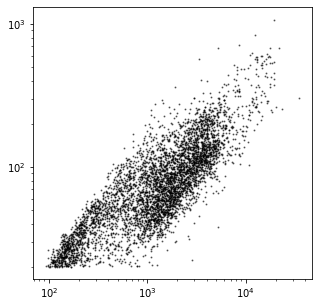

In [61]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter( df_all['area'],  (df_all['amplitude'])  , s=1, alpha=0.5, color='black', label='lambda new setup')
#ax.set_ylim(20, 1000)
#ax.set_xlim(300, 50000)

ax.set_xscale('log')
ax.set_yscale('log')


plt.show()